<a href="https://colab.research.google.com/github/srp2/ai-platform-text-classifier-shap/blob/master/my-stackoverflow-classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# You need TF 1.13.1 to deploy this on AI Platform 
!pip install tensorflow==2.5.3

import tensorflow as tf 
import pandas as pd
import numpy as np 

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.4/460.4 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.4/462.4 KB 49.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4846 sha256=f679ff771acf8b2baf0348deab70cab7c0e4653441b62bb7029788e45e3abce9
  Stored in directory: /root/.cache/pip/wheels/b6/0d/90/0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f

## Downloading and preprocessing data

In [3]:
# Authenticate to your cloud account
from google.colab import auth
auth.authenticate_user()

In [4]:
# Download the Stack Overflow data (or replace with your own text data)
!gsutil cp 'gs://cloudml-demo-lcm/SO_ml_tags_avocado_188k_v2.csv' ./

Copying gs://cloudml-demo-lcm/SO_ml_tags_avocado_188k_v2.csv...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][276.7 MiB/276.7 MiB]   19.7 MiB/s                                   
Operation completed over 1 objects/276.7 MiB.                                    


In [19]:
data = pd.read_csv('SO_ml_tags_avocado_188k_v2.csv', names=['tags', 'original_tags', 'text'], header=0)
data.head()


tags                                original_tags  \
0       matplotlib,pandas                     python,matplotlib,pandas   
1       scikitlearn,keras  python,numpy,scikit-learn,keras,grid-search   
2  matplotlib,scikitlearn     python,numpy,matplotlib,scikit-learn,nmf   
3       pandas,tensorflow         python,pandas,tensorflow,time-series   
4       matplotlib,pandas                python,matplotlib,plot,pandas   

                                                text  
0  setting xticks and yticks for scatter plot mat...  
1  gridseachcv - valueerror: found input variable...  
2  non negative matrix factorisation in python on...  
3  avocado equivalent to avocado.dataframe.resamp...  
4  how to plot on avocado python i have a data fr...

In [20]:
len(data.index)

188199

In [21]:
data = data.drop(columns=['original_tags'])
data.head()


tags                                               text
0       matplotlib,pandas  setting xticks and yticks for scatter plot mat...
1       scikitlearn,keras  gridseachcv - valueerror: found input variable...
2  matplotlib,scikitlearn  non negative matrix factorisation in python on...
3       pandas,tensorflow  avocado equivalent to avocado.dataframe.resamp...
4       matplotlib,pandas  how to plot on avocado python i have a data fr...

In [22]:
data = data.dropna()
len(data.index)


188199

In [23]:
data.head()

tags                                               text
0       matplotlib,pandas  setting xticks and yticks for scatter plot mat...
1       scikitlearn,keras  gridseachcv - valueerror: found input variable...
2  matplotlib,scikitlearn  non negative matrix factorisation in python on...
3       pandas,tensorflow  avocado equivalent to avocado.dataframe.resamp...
4       matplotlib,pandas  how to plot on avocado python i have a data fr...

In [24]:
data = shuffle(data, random_state=22)
data.head()

tags                                               text
182914  tensorflow,keras  avocado image captioning model not compiling b...
48361             pandas  return excel file from avocado with flask in f...
181447  tensorflow,keras  validating with generator (avocado) i'm trying...
66307             pandas  avocado multiindex dataframe selecting data gi...
11283             pandas  get rightmost non-zero value position for each...

In [25]:
# Encode top tags to multi-hot
tags_split = [tags.split(',') for tags in data['tags'].values]
print(tags_split)

[['tensorflow', 'keras'], ['pandas'], ['tensorflow', 'keras'], ['pandas'], ['pandas'], ['pandas'], ['pandas'], ['tensorflow'], ['pandas'], ['matplotlib'], ['matplotlib'], ['tensorflow'], ['matplotlib'], ['scikitlearn'], ['scikitlearn'], ['scikitlearn'], ['pandas'], ['keras'], ['pandas'], ['matplotlib'], ['scikitlearn'], ['pandas'], ['pandas'], ['pandas'], ['keras'], ['pandas'], ['pandas'], ['pandas'], ['tensorflow'], ['tensorflow'], ['pandas'], ['tensorflow'], ['pandas'], ['pandas'], ['pandas'], ['tensorflow'], ['matplotlib'], ['matplotlib'], ['matplotlib'], ['pandas'], ['tensorflow'], ['keras'], ['pandas'], ['matplotlib'], ['pandas'], ['scikitlearn'], ['pandas'], ['pandas'], ['matplotlib', 'scikitlearn'], ['tensorflow', 'keras'], ['pandas', 'scikitlearn'], ['pandas'], ['tensorflow'], ['pandas', 'scikitlearn'], ['scikitlearn'], ['pandas'], ['pandas'], ['pandas'], ['pandas'], ['tensorflow'], ['tensorflow'], ['pandas'], ['scikitlearn'], ['scikitlearn'], ['tensorflow'], ['pandas'], ['tens

In [26]:
data['tags'].head()

182914    tensorflow,keras
48361               pandas
181447    tensorflow,keras
66307               pandas
11283               pandas
Name: tags, dtype: object

In [27]:
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)
num_tags = len(tags_encoded[0])
print(data['text'].values[0])
print(tag_encoder.classes_)
print(tags_encoded[0])

avocado image captioning model not compiling because of concatenate layer when mask_zero=true in a previous layer i am new to avocado and i am trying to implement a model for an image captioning project.   i am trying to reproduce the model from image captioning pre-inject architecture (the picture is taken from this paper: where to put the image in an image captioning generator) (but with a minor difference: generating a word at each time step instead of only generating a single word at the end), in which the inputs for the lstm at the first time step are the embedded cnn features. the lstm should support variable input length and in order to do this i padded all the sequences with zeros so that all of them have maxlen time steps.  the code for the model i have right now is the following:    def get_model(model_name, batch_size, maxlen, voc_size, embed_size,          cnn_feats_size, dropout_rate):      # create input layer for the cnn features     cnn_feats_input = input(shape=(cnn_fe

In [28]:
# Split our data into train and test sets
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 150559
Test size: 37640


In [29]:
# Split our labels into train and test sets
train_tags = tags_encoded[:train_size]
test_tags = tags_encoded[train_size:]

In [30]:
# Pre-processing data: create our tokenizer class
%%writefile preprocess.py

from tensorflow.keras.preprocessing import text

class TextPreprocessor(object):
  def __init__(self, vocab_size):
    self._vocab_size = vocab_size
    self._tokenizer = None
  
  def create_tokenizer(self, text_list):
    tokenizer = text.Tokenizer(num_words=self._vocab_size)
    tokenizer.fit_on_texts(text_list)
    self._tokenizer = tokenizer

  def transform_text(self, text_list):
    text_matrix = self._tokenizer.texts_to_matrix(text_list)
    return text_matrix

Writing preprocess.py


In [31]:
# Create vocab from training corpus
from preprocess import TextPreprocessor

VOCAB_SIZE=400 # This is a hyperparameter, try out different values for your dataset

train_qs = data['text'].values[:train_size]
test_qs = data['text'].values[train_size:]

processor = TextPreprocessor(VOCAB_SIZE)
processor.create_tokenizer(train_qs)

body_train = processor.transform_text(train_qs)
body_test = processor.transform_text(test_qs)

In [32]:
# Preview the first input from our training data
print(len(body_train[0]))
print(body_train[0])

400
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0

## Building and training our model

In [33]:
# Save the processor state of the tokenizer
import pickle

with open('./processor_state.pkl', 'wb') as f:
  pickle.dump(processor, f)

In [34]:
def create_model(vocab_size, num_tags):
  
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(50, input_shape=(VOCAB_SIZE,), activation='relu'))
  model.add(tf.keras.layers.Dense(25, activation='relu'))
  model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [35]:
model = create_model(VOCAB_SIZE, num_tags)
model.summary()

# Train and evaluate the model
model.fit(body_train, train_tags, epochs=3, batch_size=128, validation_split=0.1)
print('Eval loss/accuracy:{}'.format(
  model.evaluate(body_test, test_tags, batch_size=128)))

# Export the model to a file
model.save('keras_saved_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                20050     
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 5)                 130       
                                                                 
Total params: 21,455
Trainable params: 21,455
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1043/1059 [============================>.] - ETA: 0s - loss: 0.1439 - accuracy: 0.8595

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1059/1059 [==============================] - 11s 5ms/step - loss: 0.1433 - accuracy: 0.8600 - val_loss: 0.1073 - val_accuracy: 0.8944
Epoch 2/3
1059/1059 [==============================] - 4s 3ms/step - loss: 0.1049 - accuracy: 0.8945 - val_loss: 0.1015 - val_accuracy: 0.8941
Epoch 3/3
295/295 [==============================] - 1s 3ms/step - loss: 0.1016 - accuracy: 0.8969
Eval loss/accuracy:[0.10156399011611938, 0.8968915939331055]


## Test our model locally

In [36]:
# Use custom model prediction to save our model + tokenizer
%%writefile model_prediction.py
import pickle
import os
import numpy as np

class CustomModelPrediction(object):

  def __init__(self, model, processor):
    self._model = model
    self._processor = processor
  
  def predict(self, instances, **kwargs):
    preprocessed_data = self._processor.transform_text(instances)
    predictions = self._model.predict(preprocessed_data)
    return predictions.tolist()

  @classmethod
  def from_path(cls, model_dir):
    import tensorflow.keras as keras
    model = keras.models.load_model(
      os.path.join(model_dir,'keras_saved_model.h5'))
    with open(os.path.join(model_dir, 'processor_state.pkl'), 'rb') as f:
      processor = pickle.load(f)

    return cls(model, processor)
 

Writing model_prediction.py


In [37]:
test_requests = [
  "How to preprocess strings in Keras models Lambda layer? I have the problem that the value passed on to the Lambda layer (at compile time) is a placeholder generated by keras (without values). When the model is compiled, the .eval () method throws the error: You must feed a value for placeholder tensor 'input_1' with dtype string and shape [?, 1] def text_preprocess(x): strings = tf.keras.backend.eval(x) vectors = [] for string in strings: vector = string_to_one_hot(string.decode('utf-8')) vectors.append(vector) vectorTensor = tf.constant(np.array(vectors),dtype=tf.float32) return vectorTensor input_text = Input(shape=(1,), dtype=tf.string) embedding = Lambda(text_preprocess)(input_text) dense = Dense(256, activation='relu')(embedding) outputs = Dense(2, activation='softmax')(dense) model = Model(inputs=[input_text], outputs=outputs) model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) model.summary() model.save('test.h5') If I pass a string array into the input layer statically, I can compile the model, but I get the same error if I want to convert the model to tflite. #I replaced this line: input_text = Input(shape=(1,), dtype=tf.string) #by this lines: test = tf.constant(['Hello', 'World']) input_text = Input(shape=(1,), dtype=tf.string, tensor=test) #but calling this ... converter = TFLiteConverter.from_keras_model_file('string_test.h5') tfmodel = converter.convert() #... still leads to this error: InvalidArgumentError: You must feed a value for placeholder tensor 'input_3' with dtype string and shape [2] [[{{node input_3}}]] ",
  "Change the bar item name in Pandas I have a test excel file like: df = pd.DataFrame({'name':list('abcdefg'), 'age':[10,20,5,23,58,4,6]}) print (df) name  age 0    a   10 1    b   20 2    c    5 3    d   23 4    e   58 5    f    4 6    g    6 I use Pandas and matplotlib to read and plot it: import pandas as pd import numpy as np import matplotlib.pyplot as plt import os excel_file = 'test.xlsx' df = pd.read_excel(excel_file, sheet_name=0) df.plot(kind='bar') plt.show() the result shows: enter image description here it use index number as item name, how can I change it to the name, which stored in column name?"
]

In [38]:
from model_prediction import CustomModelPrediction

classifier = CustomModelPrediction.from_path('.')
results = classifier.predict(test_requests)
print(results)

for i in range(len(results)):
  print('Predicted labels:')
  for idx,val in enumerate(results[i]):
    if val > 0.7:
      print(tag_encoder.classes_[idx])
  print('\n')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 499ms/step
[[0.9404001235961914, 5.772223084932193e-05, 0.000814275408629328, 0.0014938412932679057, 0.5138285160064697], [7.115749031072482e-05, 0.6318907141685486, 0.8259328007698059, 0.000464712007669732, 1.669143784965854e-05]]
Predicted labels:
keras


Predicted labels:
pandas




## Package our model and deploy to AI Platform

In [ ]:
%%writefile setup.py

from setuptools import setup

setup(
  name="so_predict",
  version="0.1",
  include_package_data=True,
  scripts=["preprocess.py", "model_prediction.py"]
)

Writing setup.py


In [ ]:
## Replace this with the name of your Cloud Storage bucket

!gsutil cp keras_saved_model.h5 gs://your_gcs_bucket/
!gsutil cp processor_state.pkl gs://your_gcs_bucket/

Copying file://keras_saved_model.h5 [Content-Type=application/octet-stream]...
/ [1 files][279.1 KiB/279.1 KiB]                                                
Operation completed over 1 objects/279.1 KiB.                                    
Copying file://processor_state.pkl [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/32.0 MiB.                                     


In [ ]:
# Replace with your bucket name below
!python setup.py sdist
!gsutil cp ./dist/so_predict-0.1.tar.gz gs://your_gcs_bucket/packages/so_predict-0.1.tar.gz

In [ ]:
# Replace with your Cloud project name
!gcloud config set project your-cloud-project

Updated property [core/project].


In [ ]:
# Create model if it hasn't been created yet
!gcloud ml-engine models create your_model_name

In [ ]:
# To use this custom code feature, fill out this form: bit.ly/cmle-custom-code-signup
!gcloud alpha ml-engine versions create v1 --model your_model_name \
--origin=gs://your_gcs_bucket/ \
--python-version=3.5 \
--runtime-version=1.13 \
--framework='TENSORFLOW' \
--package-uris=gs://your_gcs_bucket/packages/so_predict-0.1.tar.gz \
--model-class=model_prediction.CustomModelPrediction

## Generate predictions on our deployed trained model

In [ ]:
# https://stackoverflow.com/questions/55517871/how-to-preprocess-strings-in-keras-models-lambda-layer
# https://stackoverflow.com/questions/55508547/plot-histogram-for-feature-of-array-with-known-and-limited-values
%%writefile predictions.txt
"How to preprocess strings in Keras models Lambda layer? I have the problem that the value passed on to the Lambda layer (at compile time) is a placeholder generated by keras (without values). When the model is compiled, the .eval () method throws the error: You must feed a value for placeholder tensor 'input_1' with dtype string and shape [?, 1] def text_preprocess(x): strings = tf.keras.backend.eval(x) vectors = [] for string in strings: vector = string_to_one_hot(string.decode('utf-8')) vectors.append(vector) vectorTensor = tf.constant(np.array(vectors),dtype=tf.float32) return vectorTensor input_text = Input(shape=(1,), dtype=tf.string) embedding = Lambda(text_preprocess)(input_text) dense = Dense(256, activation='relu')(embedding) outputs = Dense(2, activation='softmax')(dense) model = Model(inputs=[input_text], outputs=outputs) model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) model.summary() model.save('test.h5') If I pass a string array into the input layer statically, I can compile the model, but I get the same error if I want to convert the model to tflite. #I replaced this line: input_text = Input(shape=(1,), dtype=tf.string) #by this lines: test = tf.constant(["Hello","World"]) input_text = Input(shape=(1,), dtype=tf.string, tensor=test) #but calling this ... converter = TFLiteConverter.from_keras_model_file('string_test.h5') tfmodel = converter.convert() #... still leads to this error: InvalidArgumentError: You must feed a value for placeholder tensor 'input_3' with dtype string and shape [2] [[{{node input_3}}]] "
"Change the bar item name in Pandas I have a test excel file like: df = pd.DataFrame({'name':list('abcdefg'), 'age':[10,20,5,23,58,4,6]}) print (df) name  age 0    a   10 1    b   20 2    c    5 3    d   23 4    e   58 5    f    4 6    g    6 I use Pandas and matplotlib to read and plot it: import pandas as pd import numpy as np import matplotlib.pyplot as plt import os excel_file = 'test.xlsx' df = pd.read_excel(excel_file, sheet_name=0) df.plot(kind="bar") plt.show() the result shows: enter image description here it use index number as item name, how can I change it to the name, which stored in column name? "

Writing predictions.txt


In [ ]:
# Get predictions from our trained model
predictions = !gcloud ml-engine predict --model='your_model_name' --text-instances=predictions.txt --version=v1
print(predictions)

['[[0.8507491946220398, 5.662441253662109e-07, 0.00028967857360839844, 0.0001481175422668457, 0.8072245121002197], [1.3262033462524414e-05, 0.608920693397522, 0.849873960018158, 0.0010659386171028018, 3.375759479240514e-05]]']


In [ ]:
print(tag_encoder.classes_, '\n')

for sigmoid_arr in eval(predictions[0]):
  print(sigmoid_arr)
  for idx,probability in enumerate(sigmoid_arr):
    if probability > 0.7:
      print(tag_encoder.classes_[idx])
  print('\n')

['keras' 'matplotlib' 'pandas' 'scikitlearn' 'tensorflow'] 

[0.8507491946220398, 5.662441253662109e-07, 0.00028967857360839844, 0.0001481175422668457, 0.8072245121002197]
keras
tensorflow


[1.3262033462524414e-05, 0.608920693397522, 0.849873960018158, 0.0010659386171028018, 3.375759479240514e-05]
pandas




## Interpreting our model with SHAP

In [ ]:
!pip install shap
!pip install colored

    100% |████████████████████████████████| 225kB 8.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/bf/26/bd/912db1314f1cef0171d9b7f128dd01e8b8c92ed8d0062e632d
Successfully built shap
  Stored in directory: /root/.cache/pip/wheels/52/c3/b7/ac21460710230feb409fee89bf594c4f2660ff7b67491d128f
Successfully built colored


In [ ]:
import shap
attrib_data = body_train[:200]
explainer = shap.DeepExplainer(model, attrib_data)

num_explanations = 25
shap_vals = explainer.shap_values(body_test[:num_explanations])

Using TensorFlow backend.


In [ ]:
words = processor._tokenizer.word_index

In [ ]:
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup
print(word_lookup[:100])

['', '0', 'the', 'avocado', 'i', '1', 'to', 'a', 'in', '2', 'and', 'is', 'of', 'for', '3', 'x', 'data', 'this', 'with', 'df', 'as', '5', 'it', 'import', '4', 'from', 'gt', 'y', 'that', 'have', 'model', 'dataframe', 'file', 'self', 'but', '00', "'", 'my', 'on', 'np', '10', 'train', 'how', 'python', 'if', 'not', 'get', '7', 'line', '6', '01', 'be', 'like', 'lt', 'using', 'c', 'nan', 'am', 'column', 'py', 'name', 'code', 'input', 'index', 'values', 'can', 'size', 'do', 'plot', 'print', 'columns', 'b', 'so', 'value', 'lib', 'shape', 'set', '8', 'test', 'want', 'error', 'are', 'output', 'an', 'true', 'packages', '12', 'use', 'time', 'n', 'batch', 'return', 'or', 'add', 'by', 'def', 'would', 'list', 'when', '9']


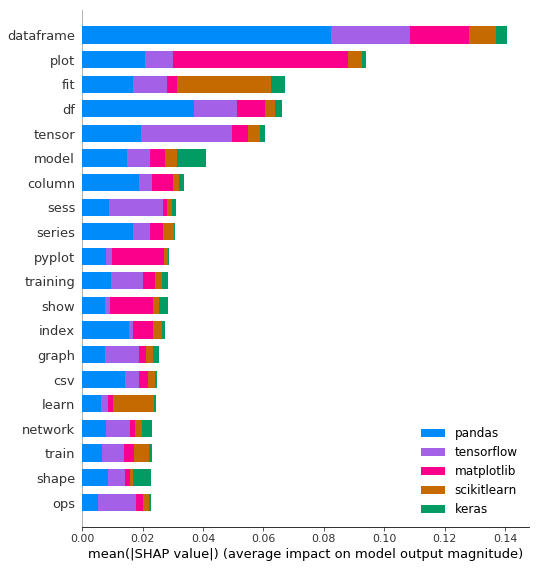

In [ ]:
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=tag_encoder.classes_)

In [ ]:
import colored
import re 
def colorprint(question, pos, neg):
  # Split question string on multiple chars
  q_arr = []
  q_filtered = filter(None,re.split("[, .()]+", question))
  for i in q_filtered:
    q_arr.append(i)

  color_str = []
  for idx,word in enumerate(q_arr):
    if word in pos:
      color_str.append(colored.fg("blue") + word)
    elif word in neg:
      color_str.append(colored.fg("light_red") + word)
    else:
      color_str.append(colored.fg('black') + word)

    # For wrapped printing
    if idx % 15 == 0 and idx > 0:
      color_str.append('\n')

  print(' '.join(color_str) + colored.fg('black') + " ")

In [ ]:
# Print highlighted signal words for a few questions
examples_to_print = [0,7,20,22,24]

for i in range(len(examples_to_print)):
  
  # Print the actual labels
  actual = test_tags[examples_to_print[i]]
  num_labels = np.sum(actual)

  actual_labels = np.argpartition(actual, -num_labels)[-num_labels:]
  
  # Print the predicted labels
  print('Predicted labels:')
  pred_tag = model.predict([[body_test[examples_to_print[i]]]])
  for idx,tagprob in enumerate(pred_tag[0]):
    if tagprob > 0.8:
      print(tag_encoder.classes_[idx])
  print('\n')

  # Get the highest and lowest signaling words
  for idx,tag in enumerate(pred_tag[0]):
    if tag > 0.7:
      attributions = shap_vals[idx][examples_to_print[i]]
      top_signal_words = np.argpartition(attributions, -5)[-5:]
      pos_words = []
      for word_idx in top_signal_words:
        signal_wd = word_lookup[word_idx]
        pos_words.append(signal_wd)

      negative_signal_words = np.argpartition(attributions, 5)[:5]
      neg_words = []
      for word_idx in negative_signal_words:
        signal_wd = word_lookup[word_idx]
        neg_words.append(signal_wd)
      colorprint(test_qs[examples_to_print[i]],pos_words, neg_words)
  print('\n')

Predicted labels:
pandas


i want to subtract each column from the previous non-null column using the diff function i 
 have a long list of columns and i want to subtract the previous column from 
 the current column and replace the current column with the difference so if i have: 
 a b c d 1 nan 3 7 3 nan 8 10 2 nan 6 
 11 i want the output to be: a b c d 1 nan 2 4 
 3 nan 5 2 2 nan 4 5 i have been trying to use this 
 code: df2 = df1 diff axis=1 but this does not produce the desired output thanks 
 in advance 


Predicted labels:
tensorflow


trying to use if in avocado's map_fn i'm trying to apply a transformation to a column 
 vector using map_fn in avocado and it's not working for the following column vector: elems 
 = np array [[1 0] [2 0] [3 0]] when i do this: avocado_m = 
 avocado map_fn lambda x: x + 1 0 elems with avocado session as sess: res 
 = sess run avocado_m print str res i get the result that i expect namely 
 this column vector: [[2 ] [3 ] [4 ]] however when i do th